### Experiments setup

In [1]:
from sksurv.ensemble import RandomSurvivalForest
from pycox import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
from sksurv.datasets import load_veterans_lung_cancer
feats, surv_label_structarray = load_veterans_lung_cancer()
feat_cols = feats.columns.values
surv_label = np.array([surv_label_structarray["Survival_in_days"], 
                       surv_label_structarray["Status"]]).T
surv_times, surv_inds = surv_label[:, 0], surv_label[:, 1]
surv_label_df = pd.DataFrame(surv_label, columns=['surv_time', 'surv_indicator'])

### Survival label Analysis

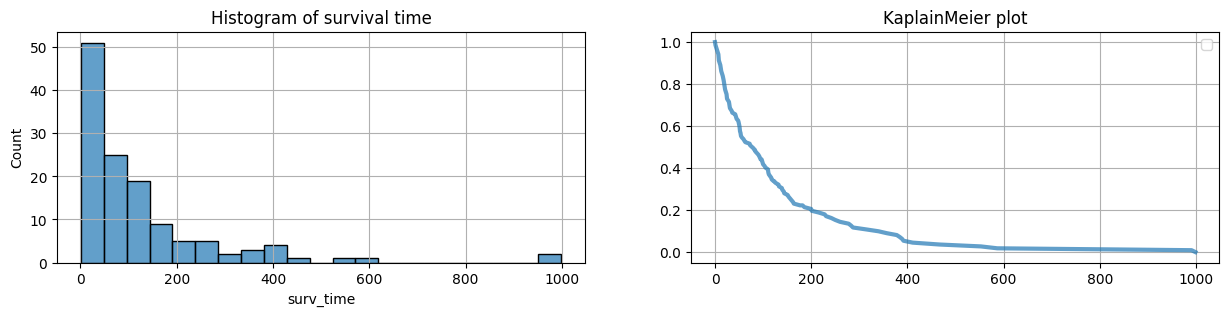

In [6]:
_, ax = plt.subplots(1, 2, figsize=(15, 3))

# Plot the hist plot
sns.histplot(data=surv_label_df[surv_label_df.surv_indicator == 1], x = 'surv_time', ax=ax[0], alpha=0.7)
ax[0].grid()
ax[0].set_title("Histogram of survival time")

# Plot the KaplainMeier plot
ax[1].grid()
ax[1].set_title("KaplainMeier plot")

kmf = KaplanMeierFitter()
kmf.fit(surv_times, surv_inds, label='kmf')
time = kmf.survival_function_.index.values
mean = kmf.survival_function_['kmf'].values
ax[1].plot(time, mean, linewidth=3, alpha=0.7)
ax[1].legend()
plt.show()

In [8]:
print("Censoring percentage {:.2f} %".format(100 * (1 - (sum(surv_inds) / len(surv_inds)))))

Censoring percentage 6.57 %


### Feature Analysis

In [11]:
feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age_in_years           137 non-null    float64 
 1   Celltype               137 non-null    category
 2   Karnofsky_score        137 non-null    float64 
 3   Months_from_Diagnosis  137 non-null    float64 
 4   Prior_therapy          137 non-null    category
 5   Treatment              137 non-null    category
dtypes: category(3), float64(3)
memory usage: 4.2 KB


In [13]:
# Split numerical and categorical features
numeric_feat_cols = feats.select_dtypes(include=[np.dtype('int64'), np.dtype('float64')]).columns.tolist()
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

#### Categorical features

In [16]:
def plot_count_kmf(featuresDF, surv_labels):
    """Plot count plot and KaplainMeier plot for categorical or ordinal features.
    
    Parameters
    ----------
    featureDF: pandas DataFrame
        The dataframe contains the set of features
    targetDF: pandas DataFrame
        The dataframe contains the corresponding target (saleprice)
    """
    # Visualize the distribution of categorical features
    for featureName in featuresDF.columns:
        feat_df = featuresDF[featureName]
        feat_values = feat_df.drop_duplicates().values
        palette = {}
        for i in range(len(feat_values)):
            palette[feat_values[i]] = sns.color_palette('colorblind')[i]
        #print(palette)
        #sns.set_palette(palette)
        _, ax = plt.subplots(1, 2, figsize=(15, 3))

        # Plot the count plot
        sns.countplot(data=featuresDF, x = featureName, hue = featureName, ax=ax[0], alpha=0.7, palette=palette)
        ax[0].grid()
        ax[0].set_title("Count plot")

        # Plot the strip plot
        #sns.violinplot(x=featuresDF[featureName], y=targetDF.SalePrice,  ax=ax[1])

        surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
        ax[1].grid()
        ax[1].set_title("KaplainMeier plot")
        
        kmf = KaplanMeierFitter()
        for i in range(len(feat_values)):
            value = feat_values[i]
            kmf.fit(surv_times[feat_df.values == value], surv_inds[feat_df.values == value], label=value)
            time = kmf.survival_function_.index.values
            mean = kmf.survival_function_[value].values
            ax[1].plot(time, mean, linewidth=3, color=palette[value], label=value, alpha=0.7)
        ax[1].legend()


        # Adjust the orientation of the names in x-axis to avoid overlapping
        #if len(plt.xticks()[1]) >= 5:
            #ax[0].set_xticklabels(labels=plt.xticks()[1], rotation=70)
            #ax[1].set_xticklabels(labels=plt.xticks()[1], rotation=70)

        # Add the title
        plt.suptitle(featureName, weight="semibold")

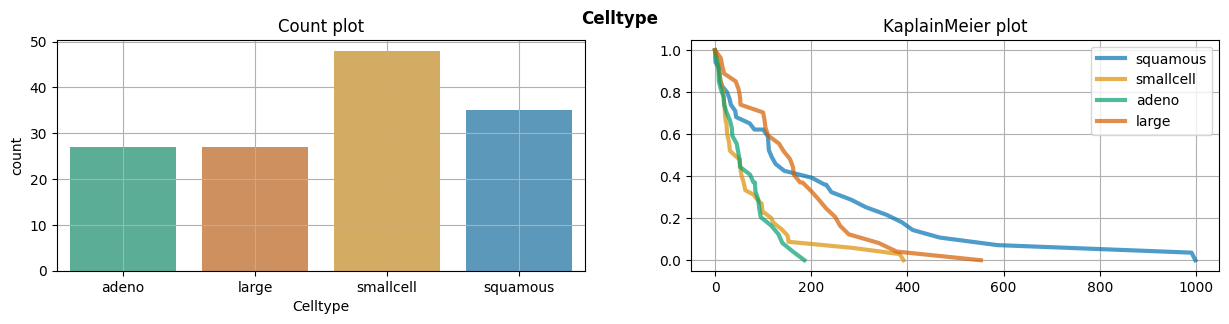

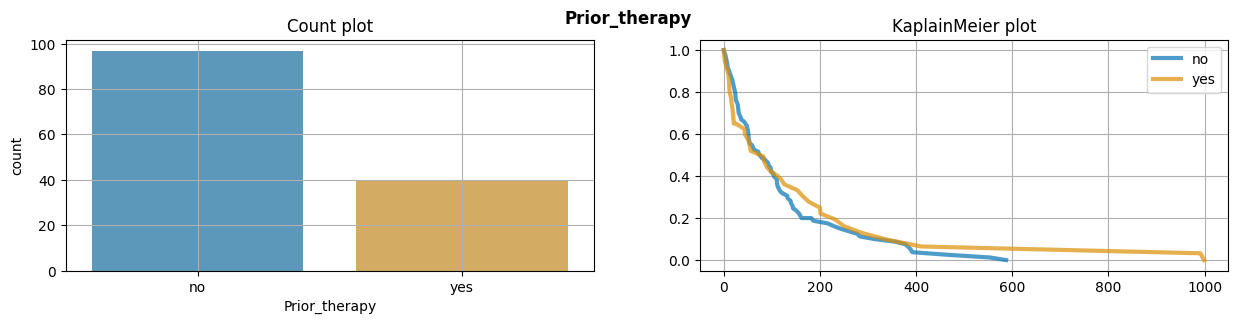

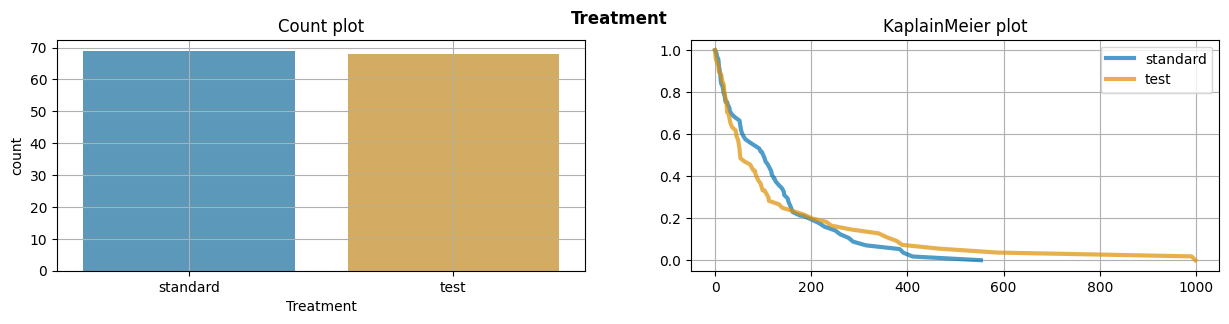

In [18]:
plot_count_kmf(feats[cate_feat_cols], surv_label)

#### Numerical features

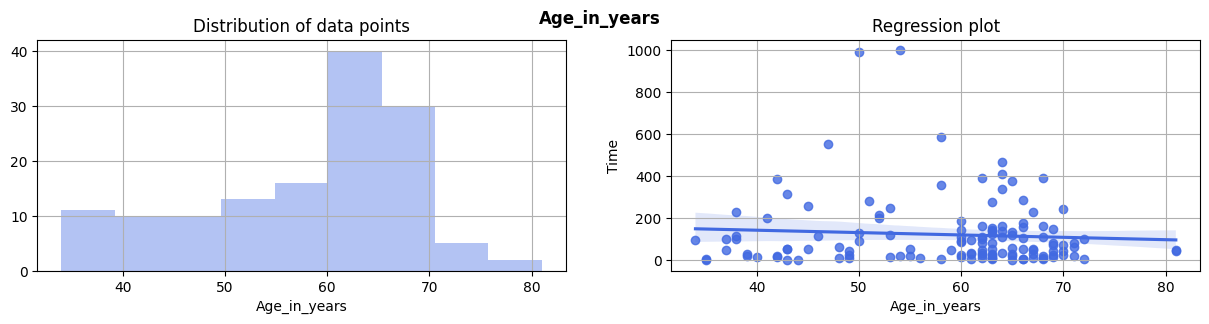

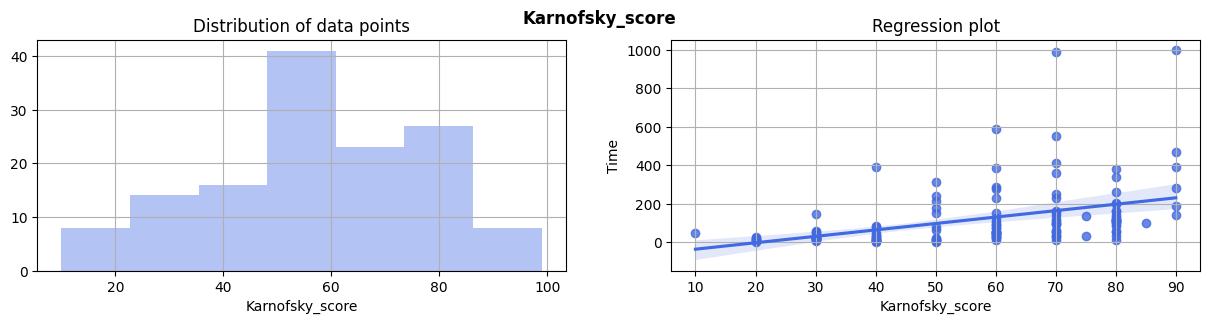

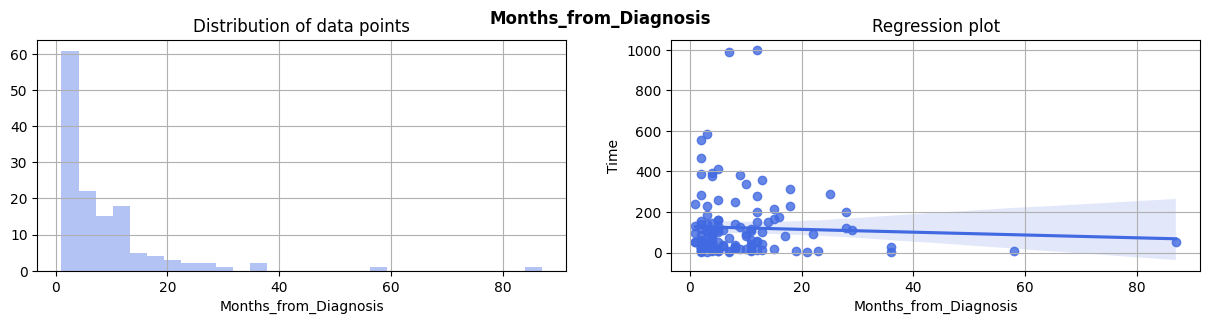

In [21]:
# Visualize only non-missing features
numericalFeaturesDF = feats[numeric_feat_cols]
for featureName in numericalFeaturesDF.columns:
    _, ax = plt.subplots(1, 2, figsize=(15, 3))
    
    # Plot the distribution
    sns.distplot(numericalFeaturesDF[featureName], 
                 kde=False, ax=ax[0], color="royalblue")
    ax[0].grid()
    ax[0].set_title("Distribution of data points")
    
    # Plot the regression line in a scatter plot
    sns.regplot(x=numericalFeaturesDF[featureName][surv_inds==1], y=surv_times[surv_inds==1], 
                ax=ax[1], color="royalblue")
    ax[1].grid()
    ax[1].set_title("Regression plot")
    ax[1].set_ylabel("Time")
    
    # Add the title
    plt.suptitle(featureName, weight="semibold")

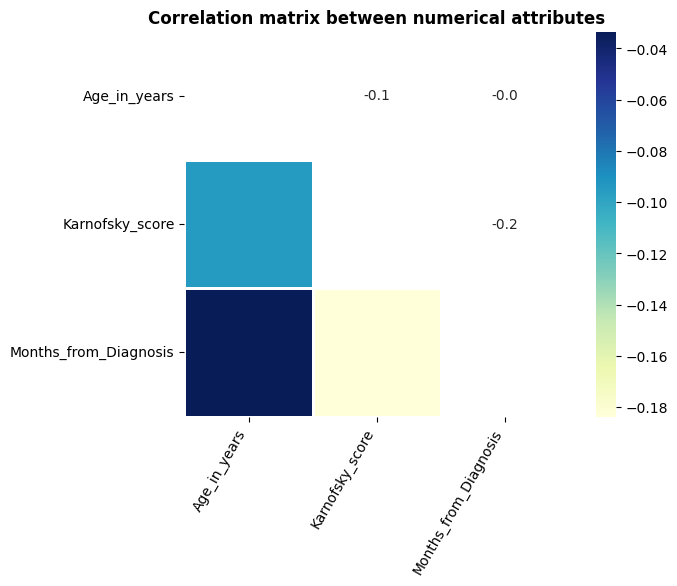

In [23]:
# Build the correlation matrix
correlationMatrix = feats[numeric_feat_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(7,5))
plt.title("Correlation matrix between numerical attributes", weight="semibold");

# Build the color correlation matrix
mask = np.zeros_like(correlationMatrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", fmt = '.1f', 
                square = True, mask=mask, linewidths=1.0);

# Build the values of correlation matrix
mask[np.triu_indices_from(mask)] = False
mask[np.tril_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap=ListedColormap(['white']), 
                square = True, fmt = '.1f', linewidths=1.0, mask=mask, 
                annot=True, annot_kws={"size":10}, cbar=False);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");

### Feature preprocessing

In [26]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_new = feats[numeric_feat_cols]
feat_enc_cols = []
enc_dict = {}
for feat_col in cate_feat_cols:
    #enc = OneHotEncoder(drop='if_binary')
    enc = OneHotEncoder(drop='first')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_new[feat_col_new] = feat_new
    feat_enc_cols.append(feat_col_new)
    enc_dict[feat_col] = enc
    
feats = feats_new
feat_cols = feats.columns.values

In [28]:
# Survival model to be explained
estimator = RandomSurvivalForest(random_state=1).fit(feats.values.astype(float), surv_label_structarray)

In [30]:
# Load model explainer
from dynsurvex.explainer import explainer
eval_times = np.unique(surv_label[:, 0][surv_label[:, 1]==1])[:-1:5]
model_explainer = explainer(estimator, feats, surv_label, 
                            encoders=enc_dict, times=eval_times)

### Prediction

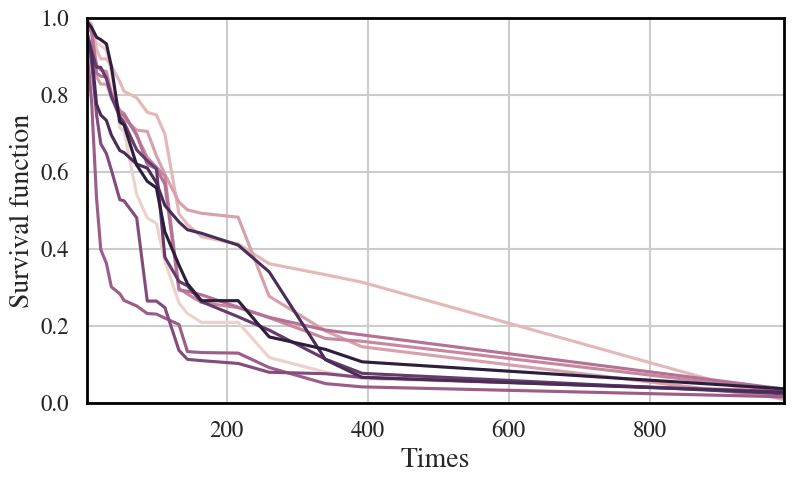

In [33]:
from dynsurvex import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data, eval_times)
prediction.plot_prediction(surv_pred, "survival")

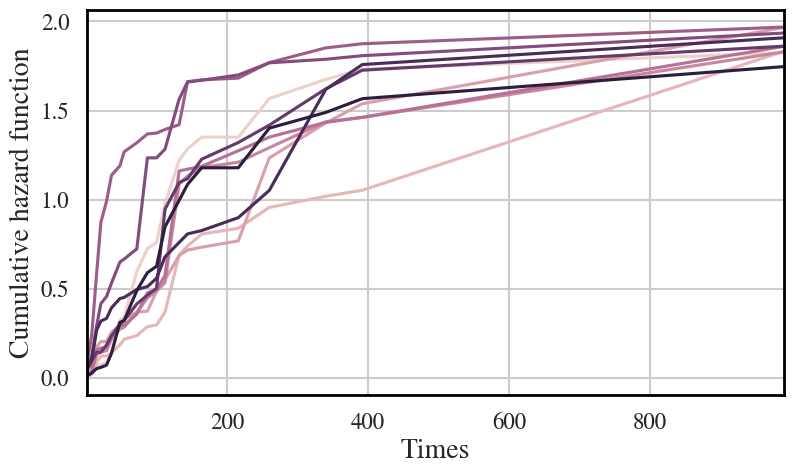

In [35]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, eval_times, prediction_type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

In [ ]:
from src.dynsurvex import performance
# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index", ylim=(0.5, 1.0))

In [ ]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score", ylim=(0,0.15))

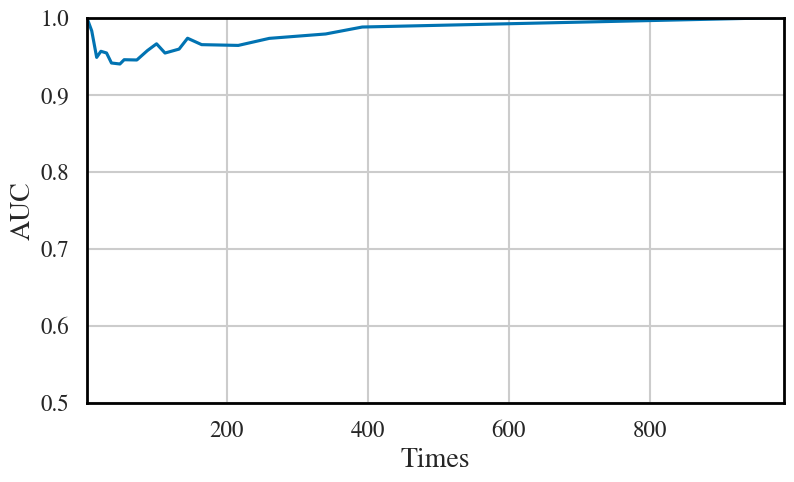

In [42]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc", ylim=(0.5,1))

### Local explaination

In [36]:
from dynsurvex import local_explaination

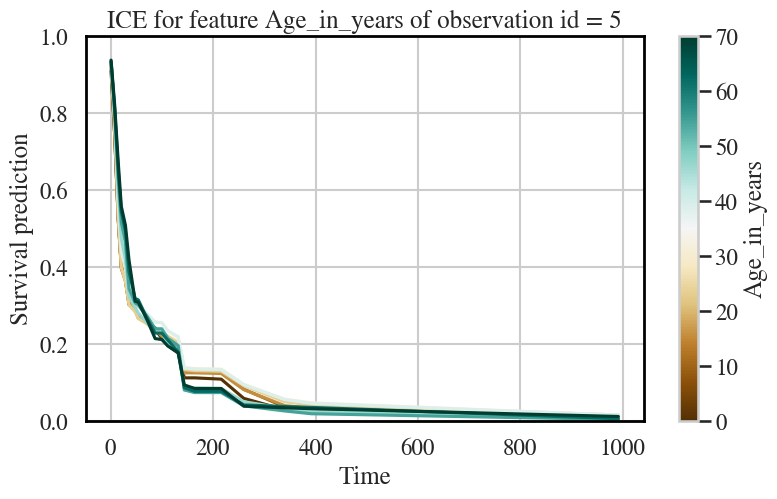

In [38]:
# individual conditional expectation
explained_feature_name = "Age_in_years"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature_name, 
                                                               num_samples=10, 
                                                               num_grid_points=10)
local_explaination.plot_ice(model_explainer, ICE_df, sample_id=5)

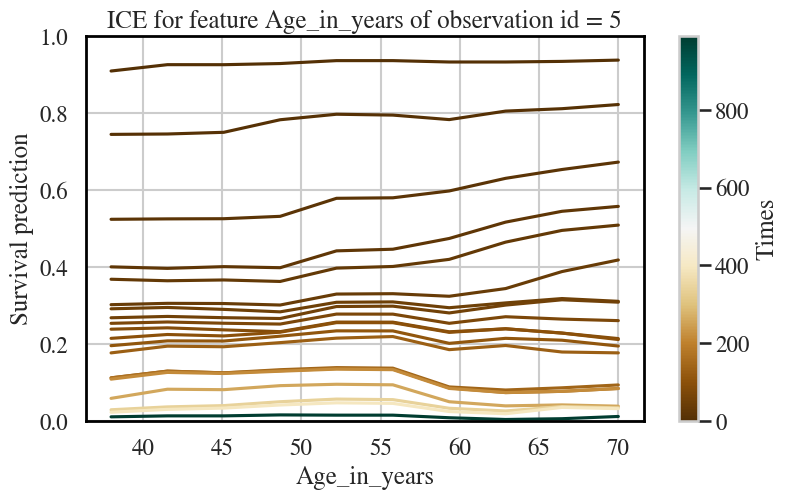

In [40]:
# individual conditional expectation
explained_feature_name = "Age_in_years"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature_name, 
                                                               num_samples=10, 
                                                               num_grid_points=10)
local_explaination.plot_ice(model_explainer, ICE_df, sample_id=5, xvar="None")

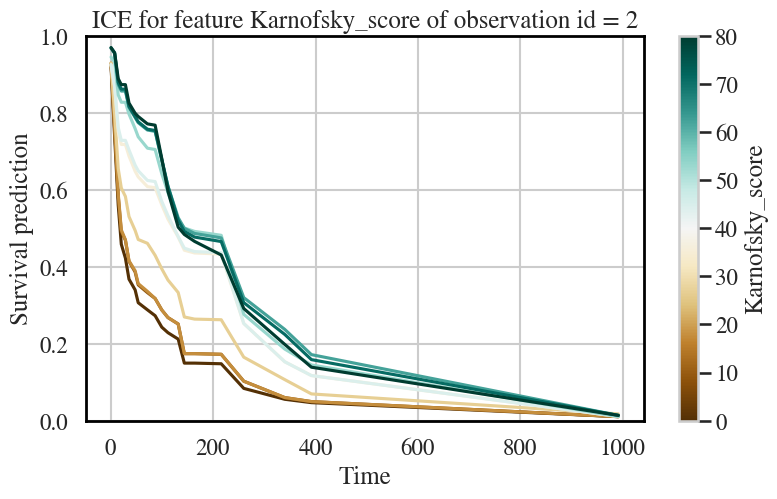

In [42]:
# individual conditional expectation
explained_feature_name = "Karnofsky_score"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature_name, 
                                                               num_samples=10, 
                                                               num_grid_points=10)
local_explaination.plot_ice(model_explainer, ICE_df, sample_id=2)

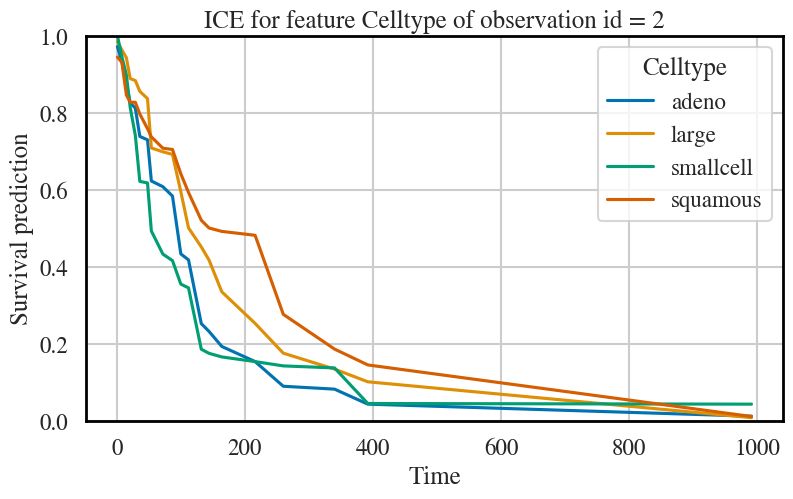

In [44]:
# individual conditional expectation
explained_feature_name = "Celltype"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature_name, 
                                                               num_samples=10, 
                                                               num_grid_points=10)
local_explaination.plot_ice(model_explainer, ICE_df, sample_id=2)

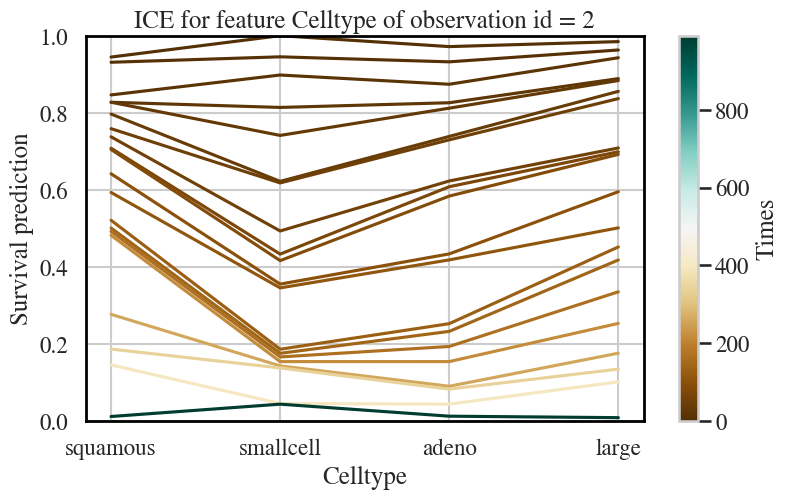

In [46]:
# individual conditional expectation
explained_feature_name = "Celltype"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature_name, 
                                                               num_samples=10, 
                                                               num_grid_points=10)
local_explaination.plot_ice(model_explainer, ICE_df, sample_id=2, xvar="None")

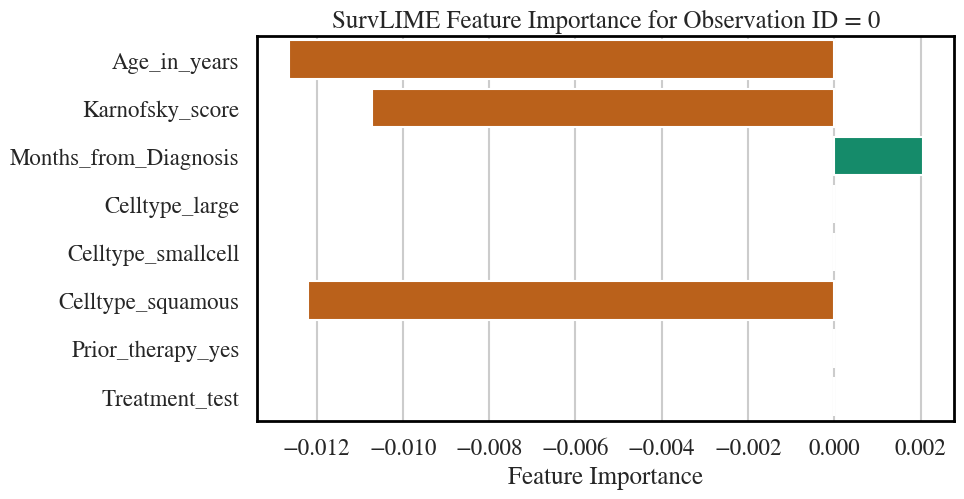

In [48]:
# SurvLIME
SurvLIME_df = local_explaination.survlime(model_explainer, explained_data, sample_id=0)
local_explaination.plot_survlime(SurvLIME_df)

Using 137 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [03:03<00:00, 183.99s/it]


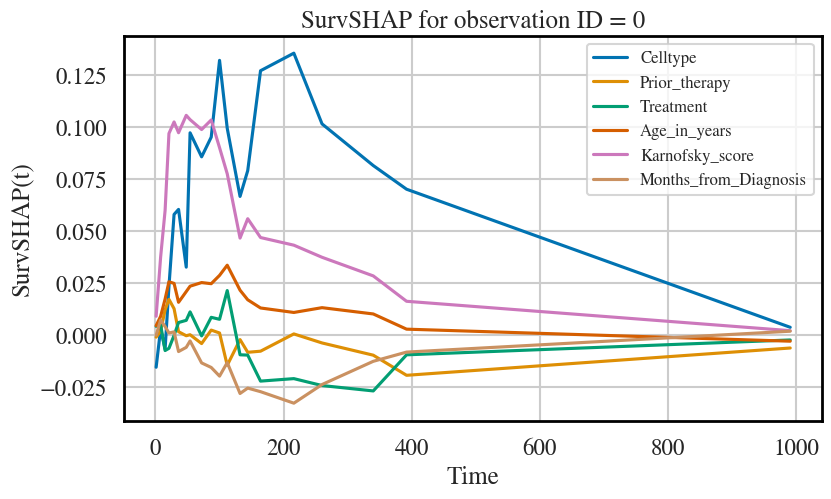

In [51]:
# SurvSHAP
SurvSHAP_df = local_explaination.survshap(model_explainer, explained_data, sample_id=0)
local_explaination.plot_survshap(SurvSHAP_df)

### Global explaination

In [52]:
from dynsurvex import global_explaination

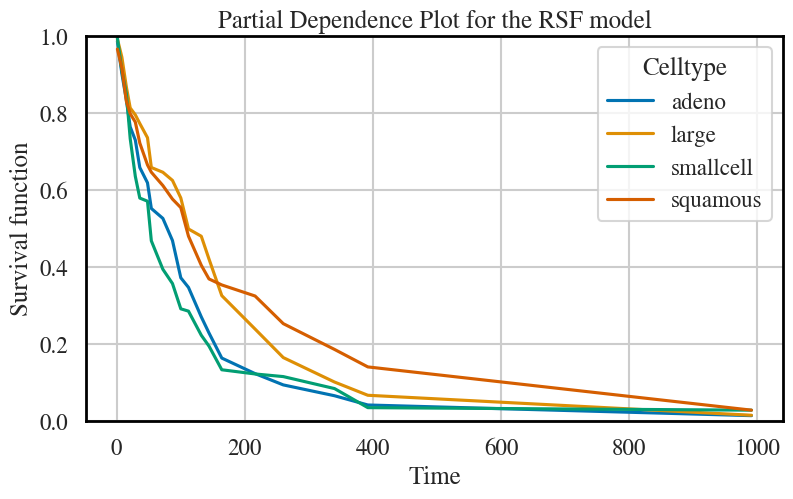

In [53]:
# partial dependence plot
explained_feature_name = "Celltype"
pdp_res_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature_name, num_samples=100)
global_explaination.plot_pdp(model_explainer, pdp_res_df)

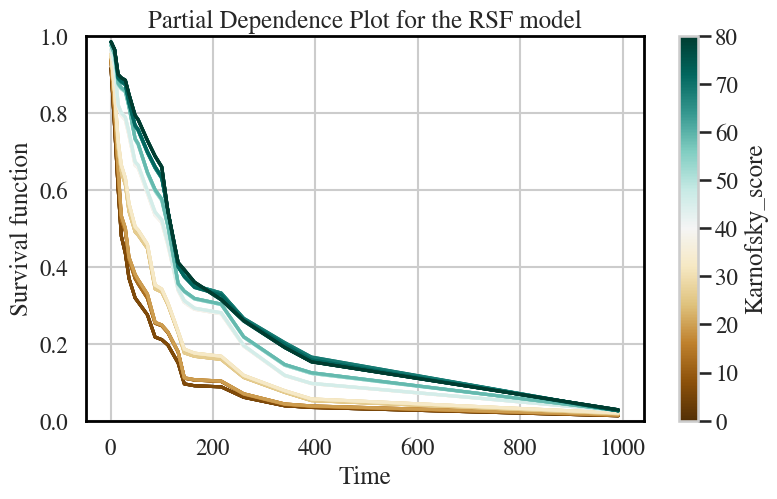

In [54]:
# partial dependence plot
explained_feature_name = "Karnofsky_score"
pdp_res_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature_name, num_samples=10)
global_explaination.plot_pdp(model_explainer, pdp_res_df)

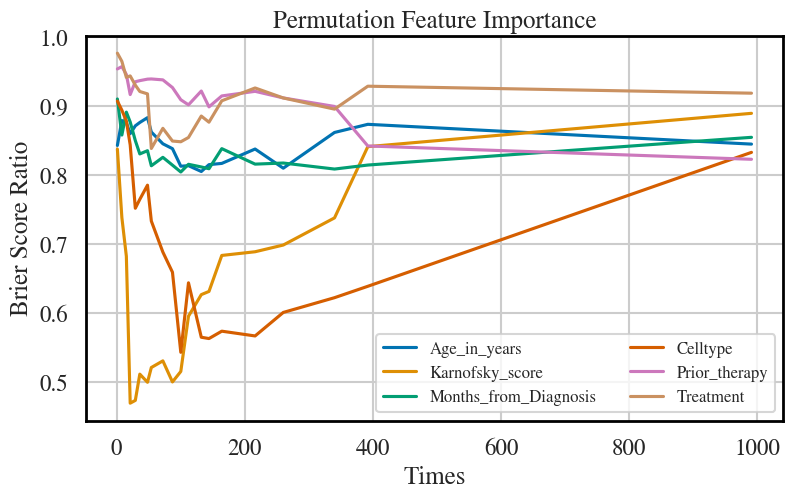

In [55]:
# permuatation feature importance
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, num_perm = 3)
global_explaination.plot_pfi(feat_importance_df, output_type="ratio")

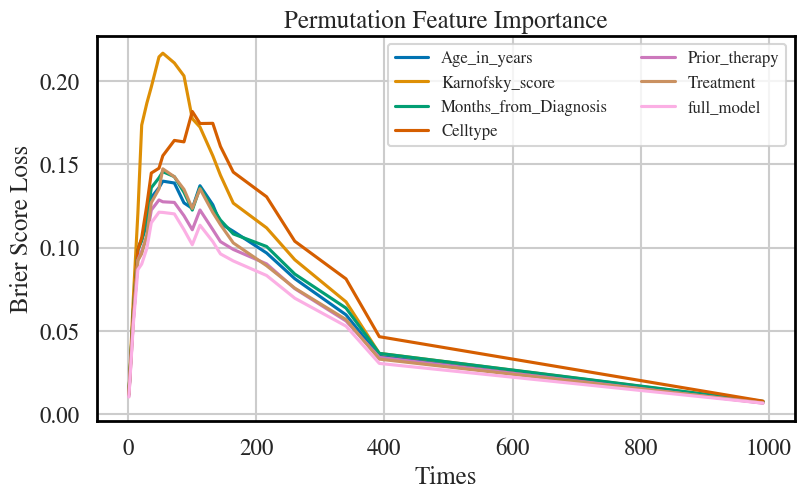

In [56]:
# permuatation feature importance
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, num_perm = 3, output_type="loss")
global_explaination.plot_pfi(feat_importance_df, output_type="loss", legend_loc='upper right')

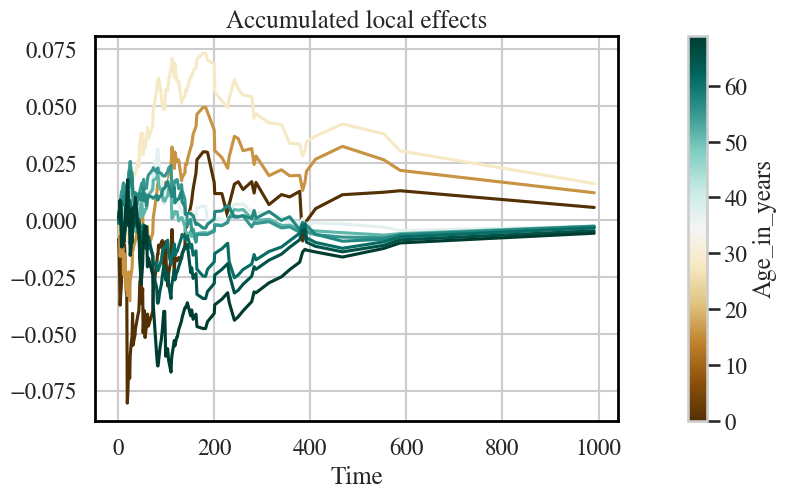

In [57]:
# accumulated local effects
explained_feature_name = "Age_in_years"
ale_res_df =  global_explaination.accumulated_local_effects_plots(model_explainer, explained_feature_name)
global_explaination.plot_ale(model_explainer, ale_res_df, explained_feature_name)

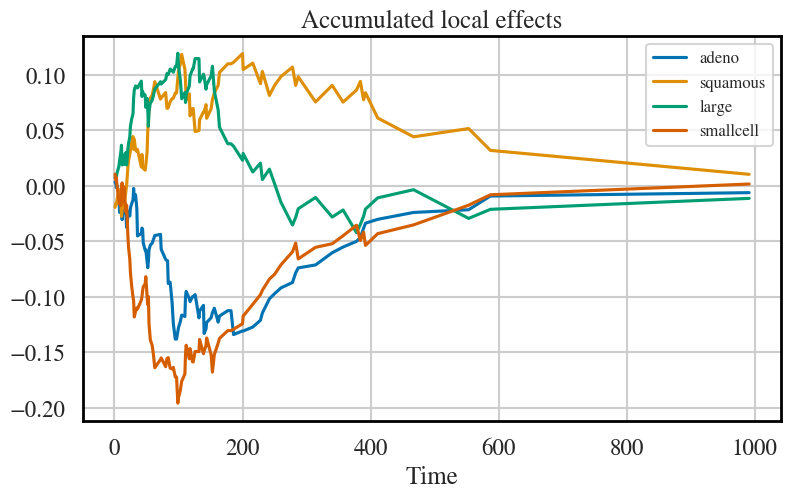

In [58]:
explained_feature_name = "Celltype"
ale_res_df =  global_explaination.accumulated_local_effects_plots(model_explainer, explained_feature_name)
global_explaination.plot_ale(model_explainer, ale_res_df,  explained_feature_name)

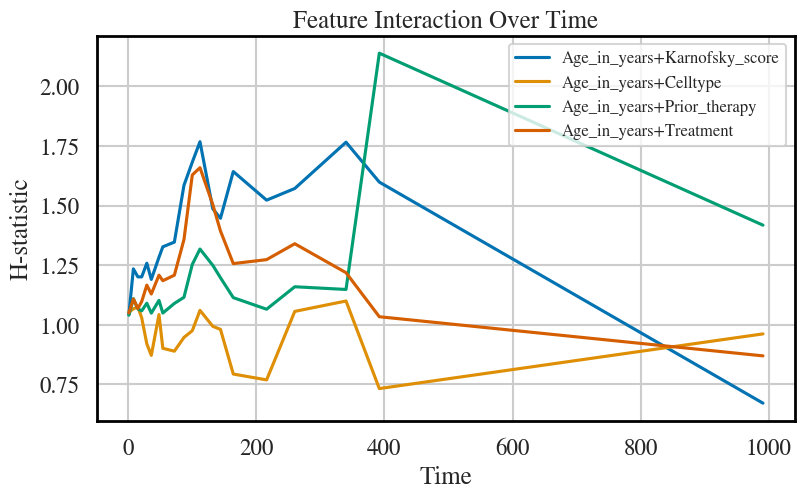

In [59]:
explained_feature_name = "Age_in_years"
H_stat_df = global_explaination.feature_interaction(model_explainer, explained_feature_name, 
                                                    num_samples=50, num_grid_points=10)
global_explaination.plot_feature_interaction(H_stat_df)

In [ ]:
explained_feature_name = "Celltype"
H_stat_df = global_explaination.feature_interaction(model_explainer, explained_feature_name, 
                                                    num_samples=50, num_grid_points=10)
global_explaination.plot_feature_interaction(H_stat_df)